# Descriptor de LBP (Local Binary Patterns)

En este notebook, se implementará el descriptor Local Binary Patterns (LBP) para analizar imágenes y extraer características relevantes. Este descriptor es útil para tareas de clasificación y reconocimiento de patrones en imágenes.

## Importar librerías necesarias

In [2]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
import random

## Variables de entorno

In [3]:
carpeta_preprocesadas = 'data/preprocesadas/'
train_normal = carpeta_preprocesadas + 'train/NORMAL/'
train_pneumonia = carpeta_preprocesadas + 'train/PNEUMONIA/'
test_normal = carpeta_preprocesadas + 'test/NORMAL/'
test_pneumonia = carpeta_preprocesadas + 'test/PNEUMONIA/'
val_normal = carpeta_preprocesadas + 'val/NORMAL/'
val_pneumonia = carpeta_preprocesadas + 'val/PNEUMONIA/'
dir_train = carpeta_preprocesadas + 'train/'
dir_test = carpeta_preprocesadas + 'test/'
dir_val = carpeta_preprocesadas + 'val/'
salida_caracteristicas = 'data/caracteristicas/lbp/'

## Muestra aleatoria de las imágenes preprocesadas

Se tomará aleatoriamente 3 imágenes por clase del conjunto de entrenamiento.

In [4]:
# Seleccionar 3 imágenes al azar de cada categoría
normal_images = os.listdir(train_normal)
neumonia_images = os.listdir(train_pneumonia)
random_normal_images = random.sample(normal_images, 3)
random_neumonia_images = random.sample(neumonia_images, 3)

## Cargar y mostrar imágenes aleatoriamente seleccionadas

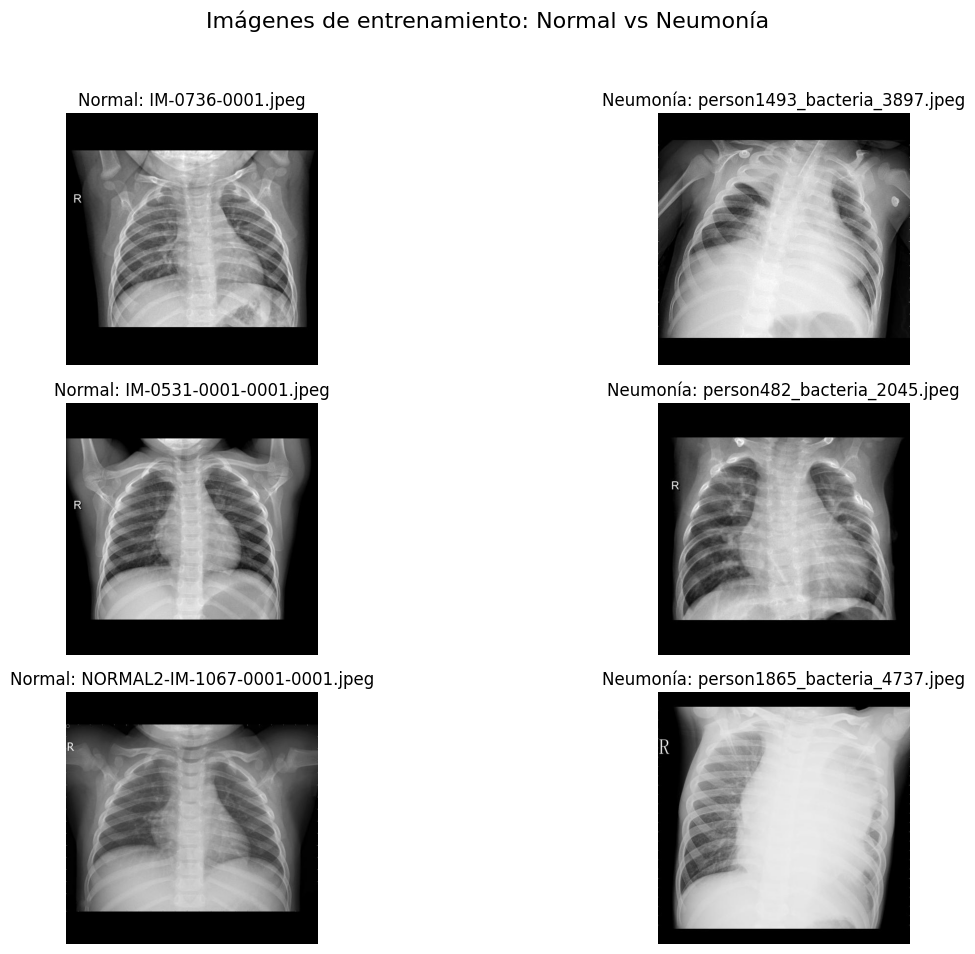

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
images = []
for i in range(3):
    # Imagen normal
    img_normal = plt.imread(os.path.join(train_normal, random_normal_images[i]))
    images.append(img_normal)
    axes[i, 0].imshow(img_normal, cmap='gray')
    axes[i, 0].set_title(f'Normal: {random_normal_images[i]}')
    axes[i, 0].axis('off')

    # Imagen con neumonía
    img_neumonia = plt.imread(os.path.join(train_pneumonia, random_neumonia_images[i]))
    images.append(img_neumonia)
    axes[i, 1].imshow(img_neumonia, cmap='gray')
    axes[i, 1].set_title(f'Neumonía: {random_neumonia_images[i]}')
    axes[i, 1].axis('off')

plt.suptitle('Imágenes de entrenamiento: Normal vs Neumonía', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Calcular y visualizar el descriptor LBP

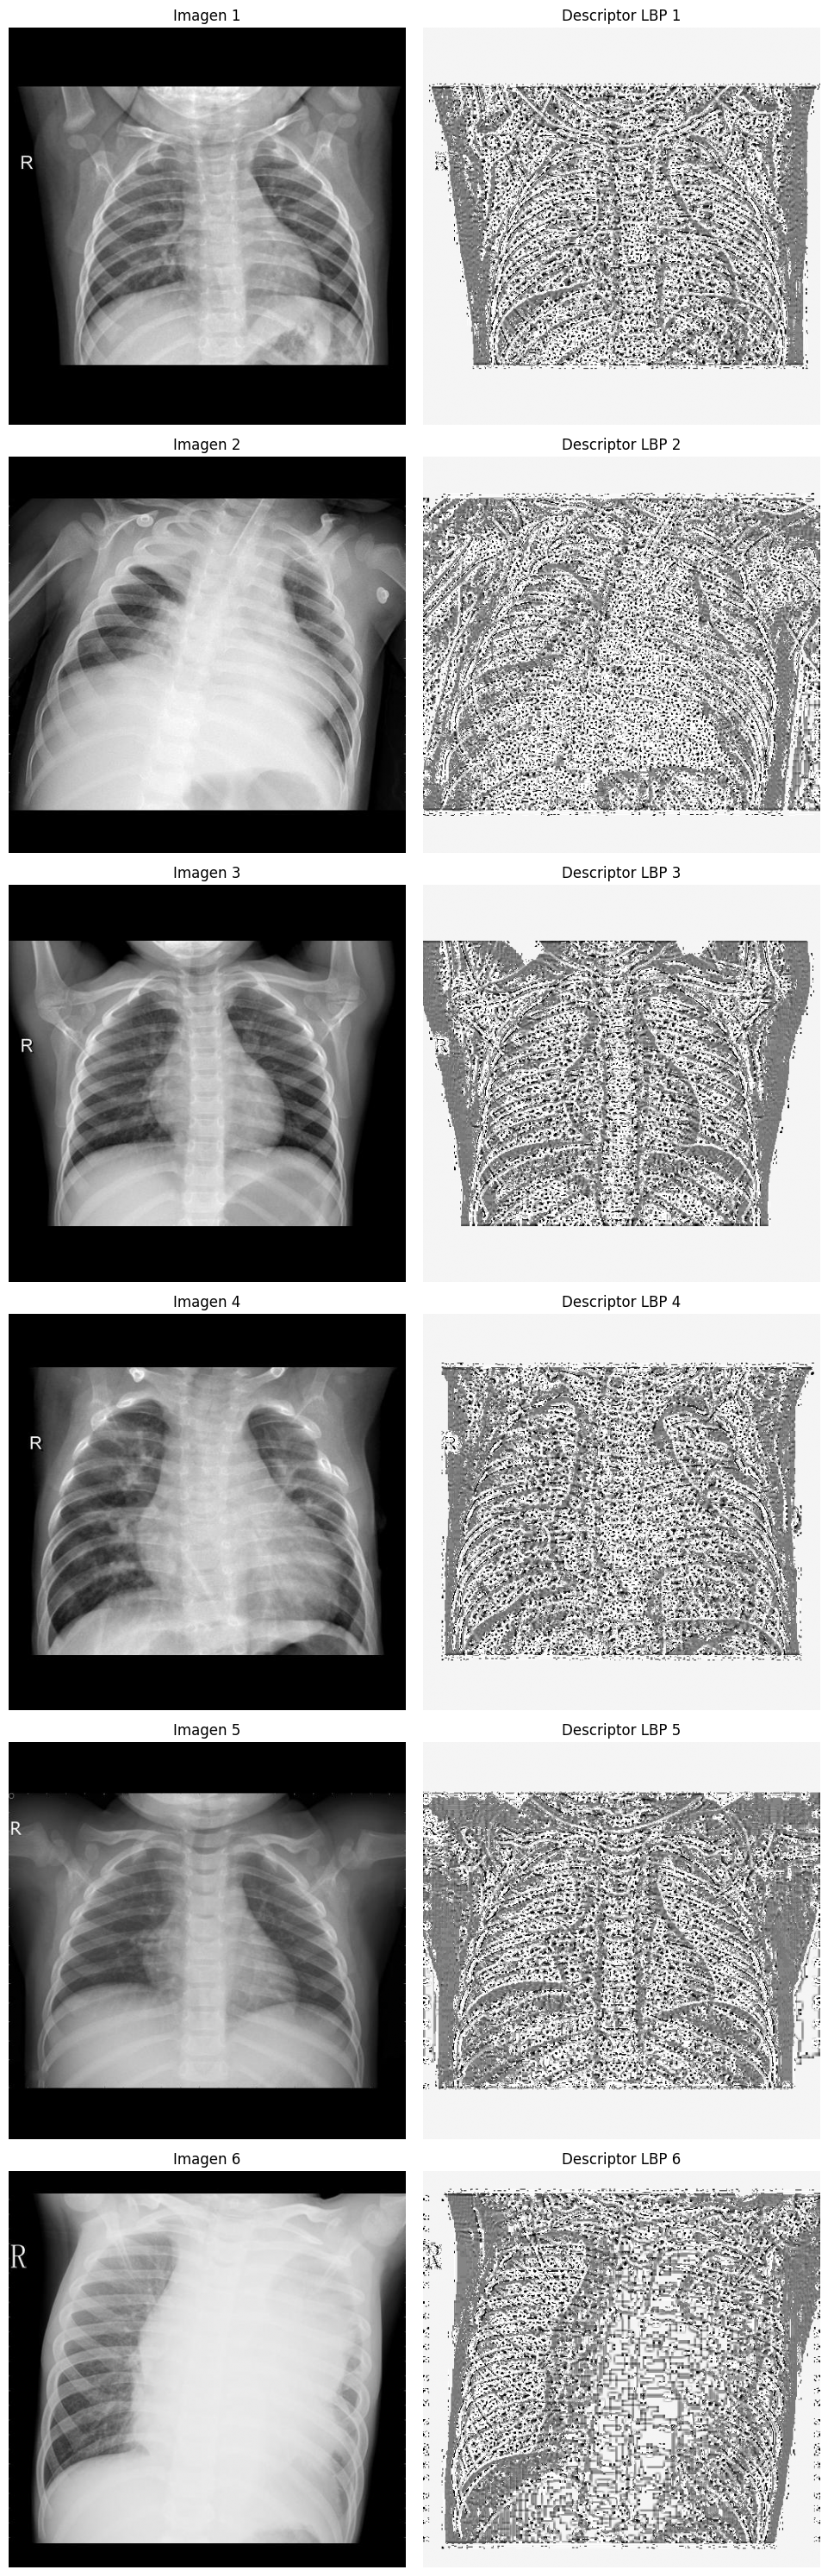

In [6]:
# Parámetros para LBP
radius = 3  # Radio del vecindario
n_points = 8 * radius  # Número de puntos en el vecindario

# Crear la figura con 2 columnas (una para la imagen y otra para el descriptor)
num_images = len(images)
fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

for i, imagen in enumerate(images):
    # Convertir la imagen a escala de grises si no lo está
    if len(imagen.shape) == 3:
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    # Mostrar la imagen original
    axes[i, 0].imshow(imagen, cmap='gray')
    axes[i, 0].set_title(f'Imagen {i + 1}')
    axes[i, 0].axis('off')

    # Calcular el descriptor LBP
    lbp = local_binary_pattern(imagen, n_points, radius, method='uniform')

    # Mostrar el descriptor LBP
    axes[i, 1].imshow(lbp, cmap='gray')
    axes[i, 1].set_title(f'Descriptor LBP {i + 1}')
    axes[i, 1].axis('off')

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()

## generarel descriptor LBP para el rest de las imágenes y guardar el resultado en un archivo .npy

In [7]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import os
import numpy as np
import cv2
from skimage.feature import local_binary_pattern

# Función para procesar una sola imagen y calcular el descriptor LBP
def procesar_imagen_lbp(img_name, input_dir, n_points, radius):
    try:
        img_path = os.path.join(input_dir, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"No se pudo cargar la imagen: {img_name}")
        # Calcular el descriptor LBP
        lbp = local_binary_pattern(image, n_points, radius, method='uniform')
        # Calcular el histograma del LBP
        (hist, _) = np.histogram(lbp.ravel(),
                                 bins=np.arange(0, n_points + 3),
                                 range=(0, n_points + 2))
        # Normalizar el histograma
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        return hist
    except Exception as e:
        print(f"Error procesando la imagen {img_name}: {e}")
        return None

# Parámetros para LBP
radius = 3
n_points = 8 * radius

# Procesar imágenes y guardar descriptores LBP
def generar_descriptores_lbp(input_dir, output_file, n_points, radius):
    features = []
    with ThreadPoolExecutor(max_workers=2) as executor:
        futures = {executor.submit(procesar_imagen_lbp, img_name, input_dir, n_points, radius): img_name for img_name in os.listdir(input_dir)}
        for future in tqdm(futures, desc=f"Procesando imágenes en {input_dir}"):
            result = future.result()
            if result is not None:
                features.append(result)
    # Convertir la lista de características a un array de NumPy
    features = np.array(features)
    # Guardar características en un archivo .npy
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    np.save(output_file, features)

# Generar descriptores para cada conjunto de datos
generar_descriptores_lbp(train_normal, os.path.join(salida_caracteristicas, 'lbp_train_normal.npy'), n_points, radius)
generar_descriptores_lbp(train_pneumonia, os.path.join(salida_caracteristicas, 'lbp_train_pneumonia.npy'), n_points, radius)
generar_descriptores_lbp(test_normal, os.path.join(salida_caracteristicas, 'lbp_test_normal.npy'), n_points, radius)
generar_descriptores_lbp(test_pneumonia, os.path.join(salida_caracteristicas, 'lbp_test_pneumonia.npy'), n_points, radius)
generar_descriptores_lbp(val_normal, os.path.join(salida_caracteristicas, 'lbp_val_normal.npy'), n_points, radius)
generar_descriptores_lbp(val_pneumonia, os.path.join(salida_caracteristicas, 'lbp_val_pneumonia.npy'), n_points, radius)

Procesando imágenes en data/preprocesadas/train/NORMAL/: 100%|██████████| 1341/1341 [00:49<00:00, 27.25it/s]
Procesando imágenes en data/preprocesadas/train/PNEUMONIA/:   0%|          | 0/3875 [00:00<?, ?it/s]
Procesando imágenes en data/preprocesadas/train/PNEUMONIA/: 100%|██████████| 3875/3875 [02:24<00:00, 26.74it/s]
Procesando imágenes en data/preprocesadas/test/NORMAL/:   0%|          | 0/234 [00:00<?, ?it/s]
Procesando imágenes en data/preprocesadas/test/NORMAL/: 100%|██████████| 234/234 [00:08<00:00, 26.15it/s]
Procesando imágenes en data/preprocesadas/test/NORMAL/: 100%|██████████| 234/234 [00:08<00:00, 26.15it/s]
Procesando imágenes en data/preprocesadas/test/PNEUMONIA/: 100%|██████████| 390/390 [00:14<00:00, 26.97it/s]
Procesando imágenes en data/preprocesadas/test/PNEUMONIA/: 100%|██████████| 390/390 [00:14<00:00, 26.97it/s]
Procesando imágenes en data/preprocesadas/val/NORMAL/: 100%|██████████| 8/8 [00:00<00:00, 27.34it/s]
Procesando imágenes en data/preprocesadas/val/NORMA

## Bibliografía

- https://aihalapathirana.medium.com/understanding-the-local-binary-pattern-lbp-a-powerful-method-for-texture-analysis-in-computer-4fb55b3ed8b8